In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
session = Session(engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year_temp = calc_temps('2016-01-01', '2016-12-31')
year_temp

[(56.0, 74.14421827631008, 84.0)]

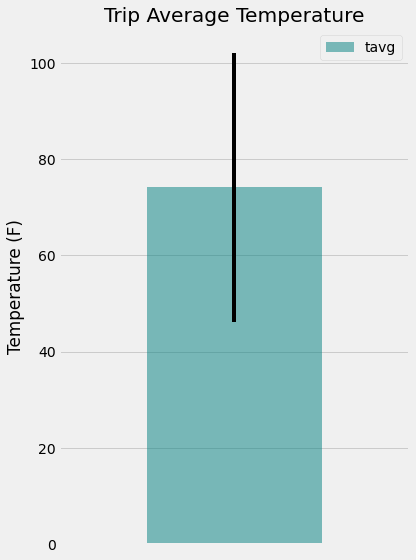

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp=pd.DataFrame(year_temp,columns=['tmin','tavg','tmax'])
avg_temp.plot.bar(y='tavg', yerr=(avg_temp['tmax'] - avg_temp['tmin']),title='Trip Average Temperature', color='teal', alpha=0.5, figsize=(6,8))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature (F)")
plt.tight_layout()


plt.savefig("Images/TripAvgTemp.png")
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    select_column = [Measurement.station, 
               Station.name, 
               Station.latitude, 
               Station.longitude, 
               Station.elevation, 
               Measurement.prcp]

    return session.query(*select_column).filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()
print(precipitation('2017-02-26','2017-03-02'))

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None)]


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
start_day = int(start_date[-2:])
end_day= int(end_date[-2:])
trip_duration = end_day - start_day + 1

# Strip off the year and save a list of strings in the format %m-%d
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

#list dates (MM-DD) of trip
trip_dates = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, trip_duration)]

#calculate normals for each date
trip_criteria = [daily_normals(date) for date in trip_dates]

print(trip_dates)
print(trip_criteria)


['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']
[[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)]]


In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df=pd.DataFrame([np.array(normal[0]) for normal in trip_criteria])
df.columns=['T-min', 'T-avg', 'T-max']
trip_dates2 = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d-%y') 
            for x in range(0, trip_duration)]

df['date']=trip_dates2
df
df1=df.set_index('date')
df1

,T-min,T-avg,T-max
date,,,
08-01-17,67.0,75.540000,83.0
08-02-17,68.0,75.603774,84.0
08-03-17,70.0,76.611111,85.0
08-04-17,69.0,76.711538,84.0
08-05-17,69.0,76.148148,82.0
08-06-17,67.0,76.250000,83.0
08-07-17,71.0,77.156863,83.0


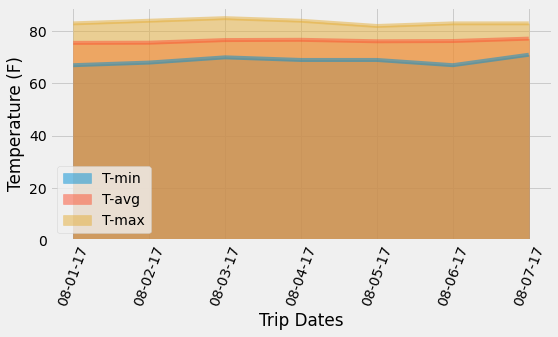

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df1.plot.area(stacked=False, figsize=(8,4))
ax.set(xlabel='Trip Dates', ylabel='Temperature (F)')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)

plt.savefig("Images/Daily_normals.png")
plt.show()

## Close Session

In [17]:
session.close()